# Phase 1 - Setup & Data Manipulation for Easier Processing

In [108]:
!pip3 install pandas
!pip3 install --upgrade pandas
!pip3 install -U seaborn
!pip3 install -U matplotlib

In [1]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# As of Pandas 1.01, json_normalize as pandas.io.json.json_normalize is deprecated and is now exposed in the top-level namespace.
from pathlib import Path
from datetime import datetime
from pandas import json_normalize

C:\Users\majum\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
df = pd.read_json (r'C:/Users/majum/Desktop/data_zipped.json', lines=True)
# df.to_csv('C:/Users/majum/Downloads/data_zipped.csv', encoding='utf-8', index=False)
# df = pd.read_csv('C:/Users/majum/Downloads/data_zipped.csv')

In [3]:
df.head()

,submit_date,ID,platform,sessionid,blocking,duration,parameters,start,subtype,ts,license
0,2021-10-28,v4/lL/HKf7A4Sqlx13944zkrx+oapLs+npaw9OUTTd4=,WindowsEditor,5314110829103121408,True,122556.0,"{""sourceView"":""UnityEditor.Toolbar""}",2021-10-28T18:43:26.8774433Z,exitPlayMode,2021-10-28 18:43:27.169 UTC,NaN
1,2021-10-28,yneAbGInS6RdkU+np9wOhJxEq4Xx8ThHdiA4c0sH1Dw=,WindowsEditor,6233676446368430080,True,489308.0,"{""sourceView"":""UnityEditor.Toolbar""}",2021-10-28T19:38:29.5106919Z,exitPlayMode,2021-10-28 19:38:30.189 UTC,NaN
2,2021-10-28,M5EjWdG90VtOp7sszGIINlbCM62WeqsU8vCNzfDZUs0=,WindowsEditor,2681689864129693184,True,384588.0,"{""sourceView"":""UnityEditor.Toolbar""}",2021-10-28T19:04:48.6154116Z,exitPlayMode,2021-10-28 19:04:49.077 UTC,NaN
3,2021-10-28,8r87+Merm5DwsC8QaREoAGMpw4nThXoYZBgxROtfTtY=,WindowsEditor,1290270805231924736,True,155529.0,"{""sourceView"":""UnityEditor.Toolbar""}",2021-10-28T21:45:33.8444707Z,exitPlayMode,2021-10-28 21:45:34.009 UTC,NaN
4,2021-10-28,8r87+Merm5DwsC8QaREoAGMpw4nThXoYZBgxROtfTtY=,WindowsEditor,1290270805231924736,True,113993.0,"{""sourceView"":""UnityEditor.Toolbar""}",2021-10-28T21:07:52.8860063Z,exitPlayMode,2021-10-28 21:07:53.694 UTC,NaN


In [4]:
list(df.columns)

['submit_date',
 'ID',
 'platform',
 'sessionid',
 'blocking',
 'duration',
 'parameters',
 'start',
 'subtype',
 'ts',
 'license']

In [5]:
#Create a new function to list out counts of missing values:
def num_missing(x):
  return sum(x.isnull())

#Applying per column:
print ("Missing values per column:")
print (df.apply(num_missing, axis=0)) #axis=0 defines that function is to be applied on each column

#Applying per row:
print ("\nMissing values per row:")
print (df.apply(num_missing, axis=1).head()) #axis=1 defines that function is to be applied on each row

Missing values per column:
submit_date        0
ID             22163
platform           0
sessionid          0
blocking           0
duration         143
parameters         0
start              0
subtype            0
ts               171
license        32978
dtype: int64

Missing values per row:
0    1
1    1
2    1
3    1
4    1
dtype: int64


In [6]:
#Data Manipulation
# Unnest the JSON field parameters for easier analysis
df = df.reset_index()
df = df.join(json_normalize(df['parameters'].map(json.loads).tolist()).add_prefix('parameters.'))\
    .drop(['parameters'], axis=1)

# Impute duration nulls
# df['duration'] = df['duration'].fillna(0).astype(np.int64)

In [7]:
#Data Manipulation
#Adding flags
#Unnnest

# Convert dates to timestamp for easier data manipulation
df = df.astype({"submit_date":"datetime64[ns]", "start":"datetime64[ns]", "ts":"datetime64[ns]"})

# Check if a user used lighting tools and assign a used_lighting flag
df['used_lighting'] = np.where((df['parameters.sourceView'].str.contains('Light', na=False)), True, False)

# Check if a user used bakeBackend and assign a used_bakeBackend flag
df['bakeBackendflag'] = df[('parameters.bakeBackend')].notnull()

# Extract hour from timestamp
df['hour'] = pd.DatetimeIndex(df['ts']).hour

# store number of sessions per user in df
total_sessions = df.groupby("ID")["sessionid"].nunique()
df = pd.merge(df,total_sessions,on='ID')
df.rename(columns = {'sessionid_y':'session_count', 'sessionid_x':'sessionid'}, inplace = True)

# Create session duration field by subtracting min timestamp of session from max timestamp of session 
df['sess_duration'] = df.groupby('sessionid') \
                        ['ts'] \
                        .transform(lambda x: (x.max()-x.min()))

# Create a field for Session duration in hours 
df['sess_duration_h'] = round(df['sess_duration']/np.timedelta64(1,'h'),2)

#Function 1
#Bin hours into periods of time over the course of the day using a function
def binning(col, cut_points, labels=None):
  #Define min and max values:
  minval = col.min()
  maxval = col.max()

  #create list by adding min and max to cut_points
  break_points = [minval] + cut_points + [maxval]

  #if no labels provided, use default labels 0 ... (n-1)
  if not labels:
    labels = range(len(cut_points)+1)

  #Binning using cut function of pandas
  colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
  return colBin

#Create bins for time of day that the session was logged
cut_points = [6.0,12.0,18.0]
labels = ["very early","day","afternoon/evening","night"]
df["hour_bin"] = binning(df["hour"], cut_points, labels)

In [8]:
df.head()

,index,submit_date,ID,platform,sessionid,blocking,duration,start,subtype,ts,...,parameters.lightmapCompression,parameters.enlighten.finalGather.rayCount,parameters.enlighten.finalGather.denoise,used_lighting,bakeBackendflag,hour,session_count,sess_duration,sess_duration_h,hour_bin
0,0,2021-10-28,v4/lL/HKf7A4Sqlx13944zkrx+oapLs+npaw9OUTTd4=,WindowsEditor,5314110829103121408,True,122556.0,2021-10-28 18:43:26.877443300,exitPlayMode,2021-10-28 18:43:27.169,...,NaN,NaN,NaN,False,False,18.0,2,0 days 00:00:15.941000,0.0,afternoon/evening
1,475721,2021-10-28,v4/lL/HKf7A4Sqlx13944zkrx+oapLs+npaw9OUTTd4=,WindowsEditor,5314110829103121408,True,1621767.0,2021-10-28 18:43:09.378232400,enterPlayMode,2021-10-28 18:43:11.228,...,NaN,NaN,NaN,False,False,18.0,2,0 days 00:00:15.941000,0.0,afternoon/evening
2,741731,2021-10-28,v4/lL/HKf7A4Sqlx13944zkrx+oapLs+npaw9OUTTd4=,WindowsEditor,8807512601416864768,True,9060060.0,2021-10-28 19:20:44.939939100,enterPlayMode,2021-10-28 19:20:54.548,...,NaN,NaN,NaN,False,False,19.0,2,0 days 00:00:00,0.0,night
3,883934,2021-10-28,v4/lL/HKf7A4Sqlx13944zkrx+oapLs+npaw9OUTTd4=,WindowsEditor,5314110829103121408,True,1216936.0,2021-10-28 18:43:18.783063600,enterPlayMode,2021-10-28 18:43:20.671,...,NaN,NaN,NaN,False,False,18.0,2,0 days 00:00:15.941000,0.0,afternoon/evening
4,1,2021-10-28,yneAbGInS6RdkU+np9wOhJxEq4Xx8ThHdiA4c0sH1Dw=,WindowsEditor,6233676446368430080,True,489308.0,2021-10-28 19:38:29.510691900,exitPlayMode,2021-10-28 19:38:30.189,...,NaN,NaN,NaN,False,False,19.0,1,0 days 00:11:54.870000,0.2,night


In [9]:
#df = df.reset_index()
#df.drop("level_0", axis=1, inplace=True)
#df.drop("index", axis=1, inplace=True)

total_hours = df.groupby("ID")["sess_duration_h"].sum()
df = pd.merge(df,total_hours,on='ID')
df.rename(columns = {'sess_duration_h_x':'sess_duration_h', 'sess_duration_h_y':'total_hours'}, inplace = True)

#df.head()

In [10]:
#Create bins based on how much time the user has spent and how engaged they are
cut_points = [10.0,20.0,50.0]
labels = ["low","medium","high","very high"]
df["use_category"] = binning(df["total_hours"], cut_points, labels)
df.head()

,index,submit_date,ID,platform,sessionid,blocking,duration,start,subtype,ts,...,parameters.enlighten.finalGather.denoise,used_lighting,bakeBackendflag,hour,session_count,sess_duration,sess_duration_h,hour_bin,total_hours,use_category
0,0,2021-10-28,v4/lL/HKf7A4Sqlx13944zkrx+oapLs+npaw9OUTTd4=,WindowsEditor,5314110829103121408,True,122556.0,2021-10-28 18:43:26.877443300,exitPlayMode,2021-10-28 18:43:27.169,...,NaN,False,False,18.0,2,0 days 00:00:15.941000,0.0,afternoon/evening,0.0,low
1,475721,2021-10-28,v4/lL/HKf7A4Sqlx13944zkrx+oapLs+npaw9OUTTd4=,WindowsEditor,5314110829103121408,True,1621767.0,2021-10-28 18:43:09.378232400,enterPlayMode,2021-10-28 18:43:11.228,...,NaN,False,False,18.0,2,0 days 00:00:15.941000,0.0,afternoon/evening,0.0,low
2,741731,2021-10-28,v4/lL/HKf7A4Sqlx13944zkrx+oapLs+npaw9OUTTd4=,WindowsEditor,8807512601416864768,True,9060060.0,2021-10-28 19:20:44.939939100,enterPlayMode,2021-10-28 19:20:54.548,...,NaN,False,False,19.0,2,0 days 00:00:00,0.0,night,0.0,low
3,883934,2021-10-28,v4/lL/HKf7A4Sqlx13944zkrx+oapLs+npaw9OUTTd4=,WindowsEditor,5314110829103121408,True,1216936.0,2021-10-28 18:43:18.783063600,enterPlayMode,2021-10-28 18:43:20.671,...,NaN,False,False,18.0,2,0 days 00:00:15.941000,0.0,afternoon/evening,0.0,low
4,1,2021-10-28,yneAbGInS6RdkU+np9wOhJxEq4Xx8ThHdiA4c0sH1Dw=,WindowsEditor,6233676446368430080,True,489308.0,2021-10-28 19:38:29.510691900,exitPlayMode,2021-10-28 19:38:30.189,...,NaN,False,False,19.0,1,0 days 00:11:54.870000,0.2,night,0.6,low


In [11]:
#Create bins based on number of sessions
cut_points = [2,5,10]
labels = ["2 or less","3 to 5","6 to 10",">10"]
df["sess_category"] = binning(df["session_count"], cut_points, labels)
df.head()

,index,submit_date,ID,platform,sessionid,blocking,duration,start,subtype,ts,...,used_lighting,bakeBackendflag,hour,session_count,sess_duration,sess_duration_h,hour_bin,total_hours,use_category,sess_category
0,0,2021-10-28,v4/lL/HKf7A4Sqlx13944zkrx+oapLs+npaw9OUTTd4=,WindowsEditor,5314110829103121408,True,122556.0,2021-10-28 18:43:26.877443300,exitPlayMode,2021-10-28 18:43:27.169,...,False,False,18.0,2,0 days 00:00:15.941000,0.0,afternoon/evening,0.0,low,2 or less
1,475721,2021-10-28,v4/lL/HKf7A4Sqlx13944zkrx+oapLs+npaw9OUTTd4=,WindowsEditor,5314110829103121408,True,1621767.0,2021-10-28 18:43:09.378232400,enterPlayMode,2021-10-28 18:43:11.228,...,False,False,18.0,2,0 days 00:00:15.941000,0.0,afternoon/evening,0.0,low,2 or less
2,741731,2021-10-28,v4/lL/HKf7A4Sqlx13944zkrx+oapLs+npaw9OUTTd4=,WindowsEditor,8807512601416864768,True,9060060.0,2021-10-28 19:20:44.939939100,enterPlayMode,2021-10-28 19:20:54.548,...,False,False,19.0,2,0 days 00:00:00,0.0,night,0.0,low,2 or less
3,883934,2021-10-28,v4/lL/HKf7A4Sqlx13944zkrx+oapLs+npaw9OUTTd4=,WindowsEditor,5314110829103121408,True,1216936.0,2021-10-28 18:43:18.783063600,enterPlayMode,2021-10-28 18:43:20.671,...,False,False,18.0,2,0 days 00:00:15.941000,0.0,afternoon/evening,0.0,low,2 or less
4,1,2021-10-28,yneAbGInS6RdkU+np9wOhJxEq4Xx8ThHdiA4c0sH1Dw=,WindowsEditor,6233676446368430080,True,489308.0,2021-10-28 19:38:29.510691900,exitPlayMode,2021-10-28 19:38:30.189,...,False,False,19.0,1,0 days 00:11:54.870000,0.2,night,0.6,low,2 or less


In [28]:
#Average number of sessions across all users
round(df.groupby("ID")["sessionid"].nunique().mean(),2)

1.52

In [20]:
# Create a subset dataframe on the condition that lighting tools were used
df_lighting = df[df['used_lighting'] == True]
df_lighting.head()

,index,submit_date,ID,platform,sessionid,blocking,duration,start,subtype,ts,...,used_lighting,bakeBackendflag,hour,session_count,sess_duration,sess_duration_h,hour_bin,total_hours,use_category,sess_category
6451,906585,2021-10-28,73i8XZyJ/VH06gpXU1oObIZPCKSjnx8FBg/O96Sb6IY=,WindowsEditor,8783197995654857728,False,8573294.0,2021-10-28 17:39:30.430414500,computeLighting,2021-10-28 17:39:39.004,...,True,True,17.0,4,0 days 00:02:02.973000,0.03,afternoon/evening,168.41,very high,3 to 5
6452,920687,2021-10-28,73i8XZyJ/VH06gpXU1oObIZPCKSjnx8FBg/O96Sb6IY=,WindowsEditor,8262643206070763520,False,13758999.0,2021-10-28 19:00:31.112072600,computeLighting,2021-10-28 19:00:44.871,...,True,True,19.0,4,0 days 02:37:03.189000,2.62,night,168.41,very high,3 to 5
6453,920688,2021-10-28,73i8XZyJ/VH06gpXU1oObIZPCKSjnx8FBg/O96Sb6IY=,WindowsEditor,8783197995654857728,False,11691616.0,2021-10-28 17:37:24.338943700,computeLighting,2021-10-28 17:37:36.031,...,True,True,17.0,4,0 days 00:02:02.973000,0.03,afternoon/evening,168.41,very high,3 to 5
6454,967402,2021-10-28,73i8XZyJ/VH06gpXU1oObIZPCKSjnx8FBg/O96Sb6IY=,WindowsEditor,5888455541594783744,False,11796466.0,2021-10-28 11:54:15.006467500,computeLighting,2021-10-28 11:54:26.802,...,True,True,11.0,4,0 days 00:55:27.546000,0.92,day,168.41,very high,3 to 5
6455,972770,2021-10-28,73i8XZyJ/VH06gpXU1oObIZPCKSjnx8FBg/O96Sb6IY=,WindowsEditor,5888455541594783744,False,8617926.0,2021-10-28 11:39:01.027066900,computeLighting,2021-10-28 11:39:09.644,...,True,True,11.0,4,0 days 00:55:27.546000,0.92,day,168.41,very high,3 to 5


In [113]:
# Export to csv in order to use a GUI view to look at the raw data and work with pivots
df_lighting.to_csv('C:/Users/majum/Desktop/data_processed.csv', index=False, encoding='utf-8')

In [45]:
# Data Manipulation to get duration from time stamps
# Calculate minimum and maximum time of each session
# Note: df_lighting is a subset of df where used_lighting is true
# Note: df_light is  a subset of all lighting tool users with their min, max and difference timestamps 

#df_time = pd.DataFrame()
#df_time["max"] = df[df['parameters.sourceView'].str.contains('Light', na=False)].groupby("sessionid")["ts"].max()
#df_time["min"] = df[df['parameters.sourceView'].str.contains('Light', na=False)].groupby("sessionid")["ts"].min()
#df_time

#df_time['min'] = pd.to_datetime(df_light['min'])
#df_time['max'] = pd.to_datetime(df_light['max'])

#df_time["diff"] = df_light["max"]- df_light["min"]
#df_time

Questions (sent to you via Slack by the PM)

1. How many Creators are using our Lighting tools? -> Answered.
metrics: parameters.SourceView, ID 

2. What user insights do we have on them? -> Answered.
metrics: ID, sessionID, platform, ts, license

3. How much time do they generally spend on our Lighting tools? -> Answered.
metrics: duration, ts, sessionid, parameters (parameters.SourceView)

4. Are they satisfied with our current offerings? 


Questions (sent to you via Slack by the EM)

1. Do Creators experience any errors when using our Lighting tools? 
metrics: parameters.scriptDebugInfoEnabled, parameters.outcome, parameters.didCompile

2. How many Creators use “bakeBackend”? -> Answered.
metrics: ID, sessionID, parameters.bakeBackend

3. Which version of “bakeBackend” is used the most? -> Answered.
metrics: ID, sessionID, parameters.bakeBackend

4. How many Creators use the Menu button in the Unity Editor to find our Lighting tools? -> Answered.
metrics: ID, sessionID, parameters.SourceView

5. What is the preferred Lightmap size? -> Answered.
metrics:ID, parameters.lightmapsize

# Phase 2 - Analysis and Answers

In [10]:
# Total instances of players logging events excluding nulls
df['ID'].count()

977937

In [14]:
# Unique Users
df['ID'].nunique()

75756

In [15]:
print ("Overall usage by time of day:\n", pd.value_counts(df["hour_bin"], sort=True))

Overall usage by time of day:
 afternoon/evening    501005
night                258696
day                  204653
very early            13412
Name: hour_bin, dtype: int64


In [ ]:
df.head()

## 1. How many Creators are using our Lighting tools?

In [16]:
# Question 1 and Question 8 (Counts)

#Number of unique users using Unity Editor
unityeditor = df[df['parameters.sourceView'].str.contains('UnityEditor', na=False)].groupby("parameters.sourceView")["ID"].nunique().sum()
#Number of unique users using Lighting Window from Unity Editor
lightingwindow = df[df['parameters.sourceView'].str.contains('UnityEditor.LightingWindow', na=False)].groupby("parameters.sourceView")["ID"].nunique().sum()
#Number of unique users using Lighting Tools including Unity Editor
lightingtools = df[df['parameters.sourceView'].str.contains('Light', na=False)].groupby("parameters.sourceView")["ID"].nunique().sum()
print ("Total number of unique users using Unity:", df['ID'].nunique())
print("Users using Unity Editor:", unityeditor)
print("Percentage of users using the Unity Editor:", round((unityeditor/(df['ID'].nunique())*100),1),"%")
print ("Users using Lighting Window from Unity Editor:", lightingwindow)
print ("Users Lighting Tools:", lightingtools)
print ("Percentage of users using Lighting Window from Unity Editor:", round((lightingwindow/unityeditor)*100,2), "%")

Total number of unique users using Unity: 75756
Users using Unity Editor: 69170
Percentage of users using the Unity Editor: 91.3 %
Users using Lighting Window from Unity Editor: 794
Users Lighting Tools: 800
Percentage of users using Lighting Window from Unity Editor: 1.15 %


## 2. What user insights do we have on them? 

In [17]:
# Question 2

print("Average number of sessions per user:", round(df.groupby("ID")["sessionid"].nunique().mean(),2))
print("Average number of sessions per users who use Lighting Tools:", round(df[df['parameters.sourceView'].str.contains('Light', na=False)].groupby("ID")["sessionid"].nunique().mean(),2) )
print("Max number of sessions per users who use Lighting Tools:", round(df[df['parameters.sourceView'].str.contains('Light', na=False)].groupby("ID")["sessionid"].nunique().max(),2))
print("Min number of sessions logged per users who use Lighting Tools:", round(df[df['parameters.sourceView'].str.contains('Light', na=False)].groupby("ID")["sessionid"].nunique().min(),2))

print("\nPlatform breakdown:\n", df[df['parameters.sourceView'].str.contains('Light', na=False)].groupby("platform")["ID"].nunique())
print('\nThe majority of Lighting Tool users are Windows users')

df[df["used_lighting"]== 'True']

print ('Time of day lighting tool users used Unity:\n', pd.value_counts(df_lighting["hour_bin"], sort=True))
print("\n Most lighting tool users engaged during the Afternoon/Evening in light with overall usage stats.")

Average number of sessions per user: 1.52
Average number of sessions per users who use Lighting Tools: 1.16
Max number of sessions per users who use Lighting Tools: 4
Min number of sessions logged per users who use Lighting Tools: 1

Platform breakdown:
 platform
LinuxEditor        2
OSXEditor         21
WindowsEditor    776
Name: ID, dtype: int64

The majority of Lighting Tool users are Windows users
Time of day lighting tool users used Unity:
 afternoon/evening    1100
night                 502
day                   492
very early             11
Name: hour_bin, dtype: int64

 Most lighting tool users engaged during the Afternoon/Evening in light with overall usage stats.


## 3. How much time do they generally spend on our Lighting tools?

In [22]:
# Average time spent by users on lighting tools overall (all sessions)
print("Average total time spent by users on lighting tools:", df_lighting.groupby(['ID'])["sess_duration_h"].sum().mean())

# Average time spent on lighting tools per session 
print("Average time spent on lighting tools per session:", df_lighting["sess_duration_h"].mean())

#Average session length
print ( "The Average session length is:", df['sess_duration_h'].mean(), "hours")

#Average total time
print ( "The Average total time spent is:", df.groupby(['ID'])["sess_duration_h"].sum().mean(), "hours")

Average total time spent by users on lighting tools: 6.483704630788488
Average time spent on lighting tools per session: 2.4610356294536806
The Average session length is: 2.5744906552262914 hours
The Average total time spent is: 33.2283836263814 hours


## 5. Do Creators experience any errors when using our Lighting tools?

In [63]:
# Explore categories of parameters.didCompile
# df['parameters.didCompile'].unique()

# Explore instances of sourceView
# df['parameters.sourceView'].unique()

#As per the documentation an instance of sourceView indicates the name of the GUIView that was active / processing events when the bake was initiated, if any
# df.groupby("parameters.sourceView")["ID"].nunique().sum()

## 6. How many Creators use “bakeBackend”?

In [35]:
# Explore data where users have used bakeBackend
# df[(df['parameters.bakeBackend'].notnull())]

In [30]:
# Number of unique users who use Bakebackend
bakeBackend_unique = df.groupby("parameters.bakeBackend")["ID"].nunique().sum()
bakeBackend_unique

bakeBackend_per_category = df.groupby("parameters.bakeBackend")["ID"].nunique()
print ("Number of unique bakeBackend users:", bakeBackend_unique)
print ("\nBreakdown of bakeBackend users by subcategory:", df.groupby("parameters.bakeBackend")["ID"].count())
print ("\nPercentage of total bakeBackend users: ",(bakeBackend_per_category/bakeBackend_unique)*100)

Number of unique bakeBackend users: 15607

Breakdown of bakeBackend users by subcategory: parameters.bakeBackend
enlighten         23334
progressivecpu    68251
progressivegpu     4204
Name: ID, dtype: int64

Percentage of total bakeBackend users:  parameters.bakeBackend
enlighten         27.071186
progressivecpu    69.129237
progressivegpu     3.799577
Name: ID, dtype: float64


## 7. Which version of “bakeBackend” is used the most?

##### Progressivecpu has the most instances of use at 68,251 unique users which constitutes of 69% of all bakeBackend users

## 8. How many Creators use the Menu button in the Unity Editor to find our Lighting tools? 

#### 794 out 800 who Unique users who use Lighting Tools use the Unity Editor to access the Lighting Window

## 9. What is the preferred (most common) Lightmap size?

In [31]:
#Most common lightmap size -> preferred lightmap size
print ("Most common lightmap size:", df["parameters.lightmapSize"].mode())

Most common lightmap size: 0    1024.0
dtype: float64


In [44]:
#Create two subsets 
# usersessions has fields ID and sessionid - gives us info on the sessions logged by each user
# df_light has fields sessionid and diff - gives us info on the duration of each session
# Join the two tables 

#usersessions = df[["ID","sessionid"]]
#df_time = df_light[['sessionid', 'diff']]
#sduration = pd.merge(usersessions,df_light,on='sessionid')
#sduration

# Graphs

In [32]:
df_lighting.head()

,index,submit_date,ID,platform,sessionid,blocking,duration,start,subtype,ts,...,used_lighting,bakeBackendflag,hour,session_count,sess_duration,sess_duration_h,hour_bin,total_hours,use_category,sess_category
6451,906585,2021-10-28,73i8XZyJ/VH06gpXU1oObIZPCKSjnx8FBg/O96Sb6IY=,WindowsEditor,8783197995654857728,False,8573294.0,2021-10-28 17:39:30.430414500,computeLighting,2021-10-28 17:39:39.004,...,True,True,17.0,4,0 days 00:02:02.973000,0.03,afternoon/evening,168.41,very high,3 to 5
6452,920687,2021-10-28,73i8XZyJ/VH06gpXU1oObIZPCKSjnx8FBg/O96Sb6IY=,WindowsEditor,8262643206070763520,False,13758999.0,2021-10-28 19:00:31.112072600,computeLighting,2021-10-28 19:00:44.871,...,True,True,19.0,4,0 days 02:37:03.189000,2.62,night,168.41,very high,3 to 5
6453,920688,2021-10-28,73i8XZyJ/VH06gpXU1oObIZPCKSjnx8FBg/O96Sb6IY=,WindowsEditor,8783197995654857728,False,11691616.0,2021-10-28 17:37:24.338943700,computeLighting,2021-10-28 17:37:36.031,...,True,True,17.0,4,0 days 00:02:02.973000,0.03,afternoon/evening,168.41,very high,3 to 5
6454,967402,2021-10-28,73i8XZyJ/VH06gpXU1oObIZPCKSjnx8FBg/O96Sb6IY=,WindowsEditor,5888455541594783744,False,11796466.0,2021-10-28 11:54:15.006467500,computeLighting,2021-10-28 11:54:26.802,...,True,True,11.0,4,0 days 00:55:27.546000,0.92,day,168.41,very high,3 to 5
6455,972770,2021-10-28,73i8XZyJ/VH06gpXU1oObIZPCKSjnx8FBg/O96Sb6IY=,WindowsEditor,5888455541594783744,False,8617926.0,2021-10-28 11:39:01.027066900,computeLighting,2021-10-28 11:39:09.644,...,True,True,11.0,4,0 days 00:55:27.546000,0.92,day,168.41,very high,3 to 5


In [33]:
sns.set_theme()

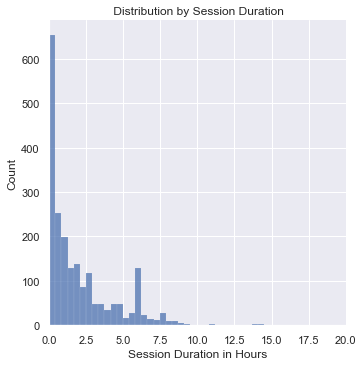

In [34]:
g = sns.displot(df_lighting, x="sess_duration_h", facet_kws={'sharey': False, 'sharex': False})
g.set(xlim=(0, 20), xlabel = 'Session Duration in Hours', title = ' Distribution by Session Duration')
plt.show()

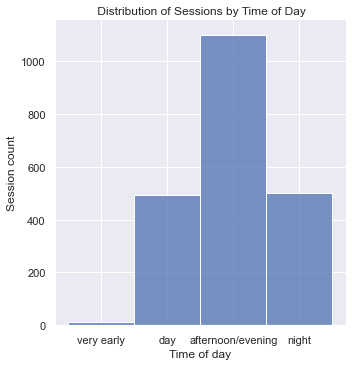

In [36]:
g = sns.displot(df_lighting, x="hour_bin", facet_kws={'sharey': False, 'sharex': False})
g.set(xlabel = 'Time of day', ylabel = 'Session count', title = ' Distribution of Sessions by Time of Day')
plt.show()

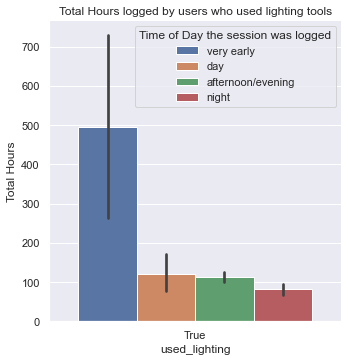

In [155]:
ax= sns.catplot(data=df_lighting, x="used_lighting", y="total_hours", hue="hour_bin", kind="bar", legend = False)
ax.set(ylabel='Total Hours', title = 'Total Hours logged by users who used lighting tools')
plt.legend(title='Time of Day the session was logged')
plt.show()